In [111]:
# LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle

In [85]:
# LOAD DATA
crime_df = pd.read_csv("crime_district.csv")

print("Number of rows after filtering:", len(crime_df))

Number of rows after filtering: 19152


In [86]:
# FILTER AGGREGATED ROWS
filtered_df = crime_df[
    (crime_df["state"] != "Malaysia") &
    (crime_df["district"] != "All") &
    (crime_df["type"] != "all")
]

print("Number of rows after filtering:", len(filtered_df))

Number of rows after filtering: 14976


In [87]:
# VIEW DATA INFO AND FIRST 5 ROWS
print("======================== DataFrame Info ========================")
filtered_df.info()
print("\n======================== First 5 Rows ========================")
print(filtered_df.head())

======================== DataFrame Info ========================
<class 'pandas.core.frame.DataFrame'>
Index: 14976 entries, 232 to 19151
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   state     14976 non-null  object
 1   district  14976 non-null  object
 2   category  14976 non-null  object
 3   type      14976 non-null  object
 4   date      14976 non-null  object
 5   crimes    14976 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 819.0+ KB

======================== First 5 Rows ========================
     state    district category            type        date  crimes
232  Johor  Batu Pahat  assault  causing_injury  2016-01-01      39
233  Johor  Batu Pahat  assault  causing_injury  2017-01-01      41
234  Johor  Batu Pahat  assault  causing_injury  2018-01-01      28
235  Johor  Batu Pahat  assault  causing_injury  2019-01-01      41
236  Johor  Batu Pahat  assault  causing_injury  2020-01-01      43


In [88]:
# MISSING VALUE CHECK
print("Missing values in each column:")
print(filtered_df.isnull().sum())

Missing values in each column:
state       0
district    0
category    0
type        0
date        0
crimes      0
dtype: int64


In [89]:
# FEATURE CONSTRUCTION
# Ensure we're working with a copy to avoid chained assignment issues
filtered_df = filtered_df.copy()

# Convert 'date' to datetime and extract the year
filtered_df['year'] = pd.to_datetime(filtered_df['date']).dt.year

# Drop the 'date' column
filtered_df.drop(columns=['date'], inplace=True)

print("\n======================== First 5 Rows ========================")
print(filtered_df.head())

print("\nNumber of rows after feature construction:", len(filtered_df))


======================== First 5 Rows ========================
     state    district category            type  crimes  year
232  Johor  Batu Pahat  assault  causing_injury      39  2016
233  Johor  Batu Pahat  assault  causing_injury      41  2017
234  Johor  Batu Pahat  assault  causing_injury      28  2018
235  Johor  Batu Pahat  assault  causing_injury      41  2019
236  Johor  Batu Pahat  assault  causing_injury      43  2020

Number of rows after feature construction: 14976


In [90]:
# SAVE CLEAN DATASET
cleaned_file_path = "cleaned_crime_dataset.csv"
filtered_df.to_csv(cleaned_file_path, index=False)

cleaned_file_path

from google.colab import files
files.download('cleaned_crime_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

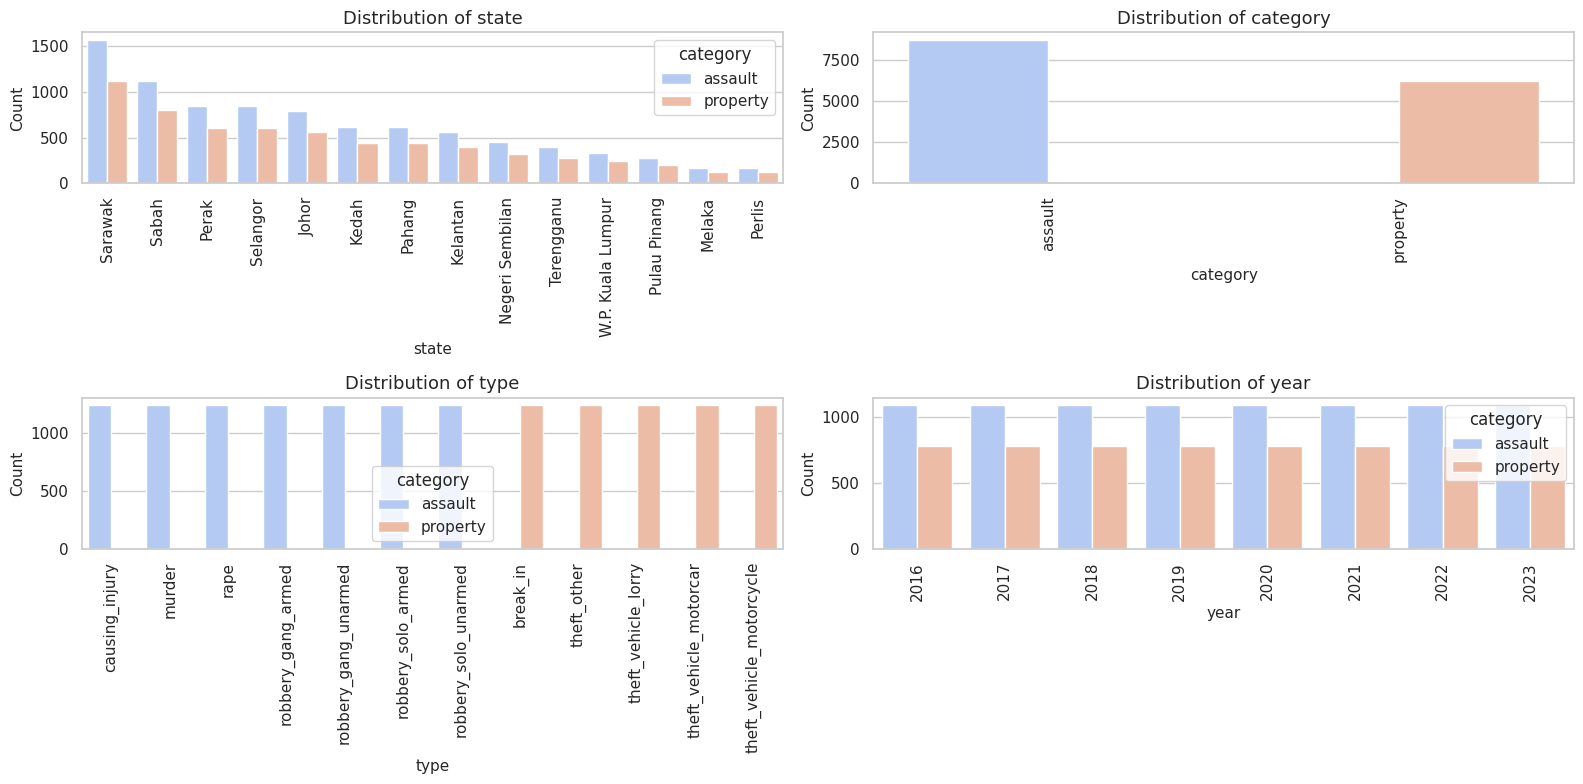

In [91]:
# COUNT PLOTS
# Adjust features to exclude 'district'
features = ['state', 'category', 'type', 'year']
n_features = len(features)
n_rows = (n_features + 1) // 2
n_cols = 2

# Create subplots for all features except 'district'
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    top_values = filtered_df[feature].value_counts().index
    data_subset = filtered_df[filtered_df[feature].isin(top_values)]

    sns.countplot(x=feature, data=data_subset, palette="coolwarm", ax=axes[i],
                  order=top_values, hue='category', dodge=True)

    axes[i].set_title(f"Distribution of {feature}", fontsize=13)
    axes[i].set_xlabel(feature, fontsize=11)
    axes[i].set_ylabel("Count", fontsize=11)
    axes[i].tick_params(axis='x', labelrotation=90)

# Remove any unused subplot axes
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


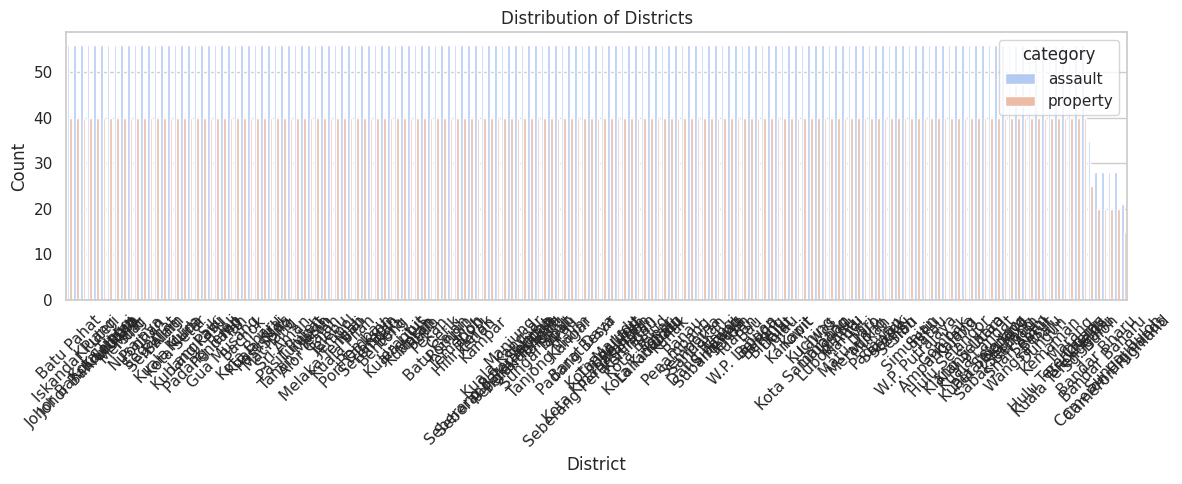

In [92]:
# Separate count plot for district
plt.figure(figsize=(12, 5))
top_districts = filtered_df['district'].value_counts().index
sns.countplot(x='district', data=filtered_df[filtered_df['district'].isin(top_districts)],
              palette="coolwarm", hue='category', dodge=True, order=top_districts)
plt.title("Distribution of Districts")
plt.xlabel("District")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


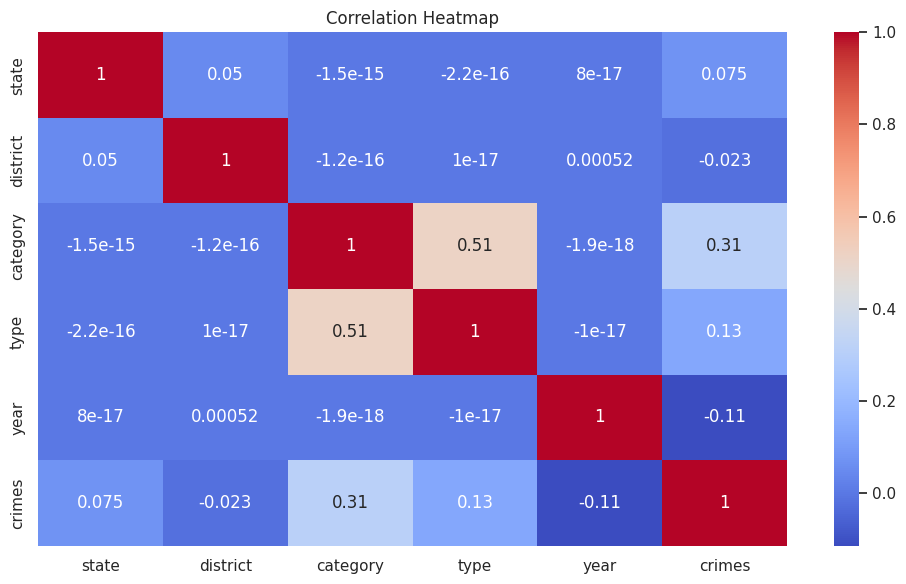

In [93]:
# CORRELATION HEATMAP
temp_df = filtered_df.copy()
for column in ['state', 'district', 'category', 'type', 'year']:
    temp_df[column] = LabelEncoder().fit_transform(temp_df[column])

plt.figure(figsize=(10, 6))
sns.heatmap(temp_df[['state', 'district', 'category', 'type', 'year', 'crimes']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [94]:
# FEATURE ENCODING - LABEL ENCODING

# Make sure we are working on a copy to avoid warnings
encoded_df = filtered_df.copy()

# Initialize a dictionary to store label encoders (useful for inverse transform later)
label_encoders = {}

# List of categorical features to encode
categorical_features = ['state', 'district', 'category', 'type']

# Apply LabelEncoder to each feature
for feature in categorical_features:
    le = LabelEncoder()
    encoded_df[feature] = le.fit_transform(encoded_df[feature])
    label_encoders[feature] = le

# Show the first few rows of the encoded dataset
encoded_df.head()


,state,district,category,type,crimes,year
232,0,9,0,1,39,2016
233,0,9,0,1,41,2017
234,0,9,0,1,28,2018
235,0,9,0,1,41,2019
236,0,9,0,1,43,2020


In [95]:
encoded_file_path = "encoded_crime_dataset.csv"
encoded_df.to_csv(encoded_file_path, index=False)

encoded_file_path

files.download('encoded_crime_dataset.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [103]:
# MODEL DEVELOPMENT
# Step 1: Define features and actual crime counts as the target
X = encoded_df[['state', 'district', 'category', 'type', 'year']]
y = encoded_df['crimes']

# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define multiple regression models (limited resources)
regression_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=50),
    "Support Vector Regressor (SVR)": SVR(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "XGBoost Regressor": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
}

# Step 4: Train, predict and evaluate
print("=================== Model Evaluation Results ===================")
print("{:<30} {:>10} {:>10} {:>10}".format("Model", "MSE", "MAE", "R²"))

for name, model in regression_models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = round(mean_squared_error(y_test, y_pred), 2)
        mae = round(mean_absolute_error(y_test, y_pred), 2)
        r2 = round(r2_score(y_test, y_pred), 4)
        print("{:<30} {:>10} {:>10} {:>10}".format(name, mse, mae, r2))
    except Exception as e:
        print("{:<30} {:>10}".format(name, f"Error: {str(e)}"))


=================== Model Evaluation Results ===================
Model                                 MSE        MAE         R²
Linear Regression                  7751.4      45.84     0.1239
Decision Tree Regressor           2109.24      13.21     0.7616
Random Forest Regressor           1552.76      12.27     0.8245
Gradient Boosting Regressor       4977.09       33.1     0.4375
Support Vector Regressor (SVR)     9895.2      37.18    -0.1183
K-Nearest Neighbors Regressor     4199.91      29.09     0.5253
XGBoost Regressor                 1588.01      17.93     0.8205


In [109]:
# ENSEMBLE MODEL
# Train top 3 models
rf_model = RandomForestRegressor(n_estimators=50)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50)
dt_model = DecisionTreeRegressor()

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Predict on test data
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
dt_pred = dt_model.predict(X_test)

# Ensemble: Average predictions
ensemble_pred = (rf_pred + xgb_pred + dt_pred) / 3

# Evaluate the ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, ensemble_pred)
mae = mean_absolute_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print("========== Ensemble (Average of Top 3 Models) ==========")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

========== Ensemble (Average of Top 3 Models) ==========
Mean Squared Error (MSE): 1230.11
Mean Absolute Error (MAE): 12.29
R² Score: 0.8610


In [112]:
# Create dictionary with trained models and encoders
ensemble_package = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "DecisionTree": dt_model,
    "LabelEncoders": label_encoders
}

# Save to a pickle file
pkl_filename = "ensemble_crime_model.pkl"
with open(pkl_filename, "wb") as f:
    pickle.dump(ensemble_package, f)

# Download if using Colab
from google.colab import files
files.download(pkl_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>